In [1]:
import requests
from bs4 import BeautifulSoup
import time

In [2]:
# Scrapping 1 page IMDb Review
def get_imdb_reviews(url, headers):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    reviews = []
    review_containers = soup.find_all('div', class_='text show-more__control')

    for container in review_containers:
        review_text = container.get_text(strip=True)
        reviews.append(review_text)

    return reviews

# PaginationKey function from IMDb
def get_pagination_key(soup):
    load_more_data = soup.find('div', {'data-key': True})
    if load_more_data:
        return load_more_data['data-key']
    return None

# Function to fetch reviews from multiple pages using AJAX requests
def get_multiple_pages_reviews(base_url, num_pages):
    all_reviews = []
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    # Fetch review from the first page
    response = requests.get(base_url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    reviews = get_imdb_reviews(base_url, headers)
    all_reviews.extend(reviews)

    pagination_key = get_pagination_key(soup)

    # Fetch another review from next page with AJAX Requests
    for _ in range(num_pages - 1):
        if not pagination_key:
            break

        ajax_url = f"https://www.imdb.com/title/tt0816692/reviews/_ajax?paginationKey={pagination_key}"
        reviews = get_imdb_reviews(ajax_url, headers)
        all_reviews.extend(reviews)

        response = requests.get(ajax_url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        pagination_key = get_pagination_key(soup)

        time.sleep(2)  # Adding a delay to avoid access limitations

    return all_reviews

# Base URL for movie reviews (first page)
base_url = 'https://www.imdb.com/title/tt0816692/reviews?ref_=tt_urv'

# Fetching Reviews from Multiple Page
reviews = get_multiple_pages_reviews(base_url, 100)

In [3]:
import pandas as pd
# Saving Reviews to Pandas
df = pd.DataFrame(reviews, columns=['Review'])

# Saving Reviews to CSV file
df.to_csv('imdb_reviews.csv', index=False)

In [4]:
import re
import nltk

In [5]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

# Preprocessing Reviews
def preprocess_review(review):
    # Menghilangkan tanda baca
    review = re.sub(r'[^\w\s]', '', review)  # Menghilangkan semua tanda baca
    # Mengonversi teks menjadi huruf kecil
    review = review.lower()
    # Menghapus kata-kata stop words
    review = ' '.join([word for word in review.split() if word not in stop_words])
    return review

# Function to count total words in preprocessed data
def count_words(preprocessed_reviews):
    total_words = sum(len(review.split()) for review in preprocessed_reviews)
    return total_words

# Read reviews from CSV
df = pd.read_csv('imdb_reviews.csv')
reviews = df['Review'].tolist()

# Preprocessing reviews
preprocessed_reviews = [preprocess_review(review) for review in reviews]

# Display total reviews and word count
print(f'Total reviews preprocessed: {len(preprocessed_reviews)}\n')

total_words_preprocessed = count_words(preprocessed_reviews)
print(f'Total words in preprocessed data: {total_words_preprocessed}')

# Save preprocessed reviews to a DataFrame
df_preprocessed = pd.DataFrame(preprocessed_reviews, columns=['Review'])

# Save preprocessed DataFrame to CSV
df_preprocessed.to_csv('preprocessed_imdb_reviews.csv', index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total reviews preprocessed: 2498

Total words in preprocessed data: 280844


In [7]:
import pandas as pd

# Define lists of positive and negative words
positive_words = {
    "excellent", "amazing", "fantastic", "good", "great", "positive", "love", "wonderful", "best", "happy",
    "awesome", "brilliant", "spectacular", "impressive", "incredible", "marvelous", "outstanding", "superb",
    "remarkable", "extraordinary", "exceptional", "terrific", "stunning", "delightful", "enjoyable", "thrilling",
    "fascinating", "entertaining", "beautiful", "heartwarming", "touching", "hilarious", "funny", "amusing",
    "satisfying", "charming", "captivating", "riveting", "masterpiece", "inspirational", "uplifting", "poignant",
    "memorable", "lovely", "compelling", "engaging", "gripping", "mesmerizing", "breathtaking", "thought-provoking",
    "outstanding", "wonderful", "superb", "remarkable", "terrific", "fantastic", "incredible", "amazing",
    "beautiful", "joyful", "heartfelt", "impressive", "splendid", "brilliant", "noteworthy", "highly", "outstanding",
    "phenomenal", "exquisite", "top-notch", "first-rate", "grand", "superior", "radiant", "elegant", "impeccable",
    "classy", "wonder", "praiseworthy", "admirable", "fantabulous", "awe-inspiring", "majestic", "stellar",
    "luminous", "positive", "super", "dazzling", "remarkable", "fabulous", "terrific", "superb", "impressive",
    "elevated", "beautiful", "radiant", "incredible", "marvelous", "outstanding", "brilliant", "superb", "fantastic",
    "excellent", "inspirational", "uplifting", "high-quality", "great", "positive", "exquisite", "memorable",
    "joyous", "charming", "breathtaking", "majestic", "astounding", "remarkable", "noteworthy", "highly", "impeccable",
    "spectacular", "stellar", "phenomenal", "fascinating", "beautiful", "enchanting", "delightful", "great",
    "wonderful", "fantastic", "superb", "brilliant", "exhilarating", "marvelous", "outstanding", "inspiring", "captivating"
}

negative_words = {
    "bad", "terrible", "awful", "poor", "negative", "hate", "worst", "boring", "disappointing", "mediocre",
    "horrible", "dreadful", "unwatchable", "lame", "stupid", "ridiculous", "forgettable", "waste", "wasted",
    "cringeworthy", "predictable", "uninteresting", "annoying", "tedious", "disastrous", "abysmal", "underwhelming",
    "overrated", "flawed", "cheesy", "corny", "cliché", "clichéd", "unoriginal", "uninspired", "weak", "flat",
    "bland", "shallow", "monotonous", "insipid", "unimpressive", "lackluster", "dull", "pointless", "incoherent",
    "implausible", "boringly", "forgettably", "unconvincing", "irritating", "unsatisfactory", "displeasing",
    "horrendous", "atrocious", "unpleasant", "nauseating", "offensive", "pathetic", "trite", "sucky", "subpar",
    "dismal", "atrocious", "ghastly", "grating", "crappy", "lamentable", "disgraceful", "abysmal", "regretful",
    "exasperating", "unfortunate", "troublesome", "unsettling", "painful", "miserable", "grievous", "unpleasant",
    "inferior", "low-grade", "infernal", "nasty", "dire", "shoddy", "deplorable", "lamentable", "unendurable",
    "disheartening", "appalling", "distressing", "regrettable", "unfortunate", "unfortunate", "poor", "horrid",
    "dreadful", "shocking", "unsettling", "deplorable", "inexcusable", "unpleasant", "insufferable", "unforgivable",
    "nasty", "abominable", "unbearable", "detestable", "awful", "miserable", "unfortunate", "deplorable",
    "horrible", "terrifying", "painful", "frustrating", "vile", "lousy", "disgusting", "gruesome", "lamentable",
    "disagreeable", "displeasing", "unfriendly", "unacceptable", "inferior", "flawed", "dismal"
}

# Function to label reviews
def label_review(review, positive_words, negative_words):
    review_words = review.split()
    positive_count = sum(1 for word in review_words if word in positive_words)
    negative_count = sum(1 for word in review_words if word in negative_words)
    if positive_count > negative_count:
        return 'positive'
    else:
        return 'negative'

# Read preprocessed reviews from CSV
df_preprocessed = pd.read_csv('preprocessed_imdb_reviews.csv')
preprocessed_reviews = df_preprocessed['Review'].tolist()

# Labeling reviews
labeled_reviews = [(review, label_review(review, positive_words, negative_words)) for review in preprocessed_reviews]

# Saving labeled reviews to a DataFrame
df_labeled = pd.DataFrame(labeled_reviews, columns=['Review', 'Label'])

# Saving DataFrame to CSV
df_labeled.to_csv('labeled_imdb_reviews.csv', index=False)

print("Labeled reviews have been saved to CSV.")

# Print the count of each label
label_counts = df_labeled['Label'].value_counts().to_dict()
print(f"Label counts: {label_counts}")

Labeled reviews have been saved to CSV.
Label counts: {'positive': 1996, 'negative': 502}


In [8]:
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from datasets import Dataset
import pandas as pd
from sklearn.metrics import classification_report

# Load the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set pad token to eos token

# Membaca data yang telah diberi label dari file CSV
df = pd.read_csv('labeled_imdb_reviews.csv')
df['label'] = df['Label'].apply(lambda x: 1 if x == 'positive' else 0)  # 1 for positive, 0 for negative

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=12)

# Create a Dataset object from pandas DataFrame
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Function to tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['Review'], padding="max_length", truncation=True, max_length=128)

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set the format of datasets to PyTorch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Load the GPT-2 model for sequence classification with dropout regularization
class GPT2ForSequenceClassificationWithDropout(GPT2ForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.transformer(input_ids, attention_mask=attention_mask, **kwargs)
        hidden_states = outputs[0]
        logits = self.score(self.dropout(hidden_states[:, -1, :]))  # Apply dropout here
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return (loss, logits) if loss is not None else logits

model = GPT2ForSequenceClassificationWithDropout.from_pretrained('gpt2', num_labels=2)  # 2 labels: positive, negative
model.config.pad_token_id = tokenizer.pad_token_id  # Set pad token ID

# Define training arguments with early stopping
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",  # Save strategy should be the same as evaluation strategy
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,  # Increase number of epochs
    weight_decay=0.01,
    logging_dir='./logs',  # Directory for storing logs
    load_best_model_at_end=True,  # Enable early stopping
    save_total_limit=2  # Limit the number of saved checkpoints
)

# Initialize Trainer with early stopping callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Add early stopping callback
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(f"Evaluation results: {results}")

# Get the classification metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return classification_report(labels, preds, target_names=['negative', 'positive'])

# Predict and compute metrics
predictions = trainer.predict(val_dataset)
metrics = compute_metrics(predictions)
print(metrics)

Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassificationWithDropout were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.352482
2,0.371200,0.316790
3,0.371200,0.484618
4,0.247000,0.443133
5,0.247000,0.468012


Evaluation results: {'eval_loss': 0.3167901039123535, 'eval_runtime': 3.593, 'eval_samples_per_second': 139.16, 'eval_steps_per_second': 17.534, 'epoch': 5.0}
              precision    recall  f1-score   support

    negative       0.71      0.70      0.70       110
    positive       0.92      0.92      0.92       390

    accuracy                           0.87       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.87      0.87      0.87       500



In [10]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from datasets import Dataset
import pandas as pd
from sklearn.metrics import classification_report

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Membaca data yang telah diberi label dari file CSV
df = pd.read_csv('labeled_imdb_reviews.csv')
df['label'] = df['Label'].apply(lambda x: 1 if x == 'positive' else 0)  # 1 for positive, 0 for negative

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=12)

# Create a Dataset object from pandas DataFrame
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Function to tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['Review'], padding="max_length", truncation=True, max_length=128)

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set the format of datasets to PyTorch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define training arguments with early stopping
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",  # Save strategy should be the same as evaluation strategy
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,  # Increase number of epochs
    weight_decay=0.01,
    logging_dir='./logs',  # Directory for storing logs
    load_best_model_at_end=True,  # Enable early stopping
    save_total_limit=2  # Limit the number of saved checkpoints
)

# Initialize Trainer with early stopping callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Add early stopping callback
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(f"Evaluation results: {results}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.320516
2,0.357700,0.444775
3,0.357700,0.454138


Evaluation results: {'eval_loss': 0.32051607966423035, 'eval_runtime': 3.3874, 'eval_samples_per_second': 147.605, 'eval_steps_per_second': 18.598, 'epoch': 3.0}


In [11]:
print(f"{results}")

{'eval_loss': 0.32051607966423035, 'eval_runtime': 3.3874, 'eval_samples_per_second': 147.605, 'eval_steps_per_second': 18.598, 'epoch': 3.0}


In [12]:
# Get predictions
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch


In [15]:
cm = confusion_matrix(labels, preds, labels=[0, 1])


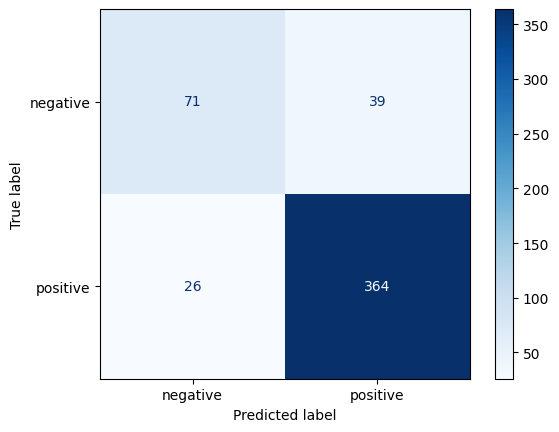

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])
disp.plot(cmap='Blues')


In [19]:
from sklearn.metrics import classification_report

# Retrieve predictions and labels from the evaluation results
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return classification_report(labels, preds, target_names=['negative', 'positive'])

# Retrieve predictions and calculate metrics
predictions = trainer.predict(val_dataset)
metrics = compute_metrics(predictions)
print(metrics)


              precision    recall  f1-score   support

    negative       0.73      0.65      0.69       110
    positive       0.90      0.93      0.92       390

    accuracy                           0.87       500
   macro avg       0.82      0.79      0.80       500
weighted avg       0.87      0.87      0.87       500



In [21]:
import re
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('./trained_model')
model = BertForSequenceClassification.from_pretrained('./trained_model')

# Function to preprocess new reviews
def preprocess_review(review):
    review = review.lower()  # Convert to lowercase
    review = re.sub(r'[^\w\s]', '', review)  # Remove punctuation
    return review

# Function to predict sentiment of new reviews
def predict_sentiment(review, model, tokenizer):
    review = preprocess_review(review)  # Preprocess the new review
    inputs = tokenizer(review, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs['attention_mask'] = (inputs['input_ids'] != tokenizer.pad_token_id).long()  # Set attention mask
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()
    return prediction

# New reviews to test, inspired by watching "Interstellar"
new_reviews = [
    "Interstellar is a mind-bending experience with breathtaking visuals and an emotionally charged story. A true masterpiece!",
    "While Interstellar had some stunning visuals, the plot was overly complex and confusing. It didn't resonate with me.",
    "The film’s exploration of space and time is profound, and Hans Zimmer's score adds so much depth. Highly recommended!",
    "Interstellar felt like a long and tedious journey. Despite its ambitious scope, I found it lacking in engaging narrative.",
    "An exceptional film with a brilliant blend of science and emotion. The ending left me in awe, truly a cinematic achievement."
]

# Make predictions for the new reviews
predictions = [predict_sentiment(review, model, tokenizer) for review in new_reviews]

# Display the prediction results
for review, prediction in zip(new_reviews, predictions):
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f'Review: {review}\nPredicted Sentiment: {sentiment}\n')


Review: Interstellar is a mind-bending experience with breathtaking visuals and an emotionally charged story. A true masterpiece!
Predicted Sentiment: Positive

Review: While Interstellar had some stunning visuals, the plot was overly complex and confusing. It didn't resonate with me.
Predicted Sentiment: Negative

Review: The film’s exploration of space and time is profound, and Hans Zimmer's score adds so much depth. Highly recommended!
Predicted Sentiment: Positive

Review: Interstellar felt like a long and tedious journey. Despite its ambitious scope, I found it lacking in engaging narrative.
Predicted Sentiment: Negative

Review: An exceptional film with a brilliant blend of science and emotion. The ending left me in awe, truly a cinematic achievement.
Predicted Sentiment: Positive

